# Introduction to Fairness in ML


## Disclaimer
This exercise explores just a small subset of  ideas and techniques relevant to fairness in machine learning; it is not the whole story!

## Learning Objectives

* Increase awareness of different types of biases that can manifest in model data.
* Explore feature data to proactively identify potential sources of bias before training a model.
* Evaluate model performace by subgroup rather than in aggregate.

## Overview

In this exercise, you'll explore datasets and evaluate classifiers with *fairness* in mind, noting the ways undesirable biases can creep into machine learning (ML).

Throughout, you will see **FairAware** tasks, which provide opportunities to contextualize ML processes with respect to fairness. In performing these tasks, you'll identify biases and consider the long-term impact of model predictions if these biases are not addressed.

## About the Dataset and Prediction Task

In this exercise, you'll work with the [Adult Census Income dataset](https://archive.ics.uci.edu/ml/datasets/Census+Income), which is commonly used in machine learning literature. This data was extracted from the [1994 Census bureau database](http://www.census.gov/en.html) by Ronny Kohavi and Barry Becker.

Each example in the dataset contains the following demographic data for a set of individuals who took part in the 1994 Census:

### Numeric Features
*   `age`: The age of the individual in years.
*   `fnlwgt`: The number of individuals the Census Organizations believes that set of observations represents.
*   `education_num`:  An enumeration of the categorical representation of education. The higher the number, the higher the education that individual achieved. For example, an `education_num` of `11` represents `Assoc_voc` (associate degree at a vocational school), an `education_num` of `13` represents `Bachelors`, and an `education_num` of `9` represents `HS-grad` (high school graduate).
*   `capital_gain`: Capital gain made by the individual, represented in US Dollars.
*   `capital_loss`: Capital loss mabe by the individual, represented in US Dollars.
*   `hours_per_week`: Hours worked per week.

### Categorical Features
*   `workclass`: The individual's type of employer. Examples include: `Private`, `Self-emp-not-inc`, `Self-emp-inc`, `Federal-gov`, `Local-gov`, `State-gov`, `Without-pay`, and `Never-worked`.
*   `education`: The highest level of education achieved for that individual.
*   `marital_status`: Marital status of the individual. Examples include: `Married-civ-spouse`, `Divorced`, `Never-married`, `Separated`, `Widowed`, `Married-spouse-absent`, and `Married-AF-spouse`.
*   `occupation`: The occupation of the individual. Example include: `tech-support`, `Craft-repair`, `Other-service`, `Sales`, `Exec-managerial` and more.
*   `relationship`:  The relationship of each individual in a household. Examples include: `Wife`, `Own-child`, `Husband`, `Not-in-family`, `Other-relative`, and `Unmarried`.
*   `gender`:  Gender of the individual available only in binary choices: `Female` or `Male`.
*   `race`: `White`, `Asian-Pac-Islander`, `Amer-Indian-Eskimo`, `Black`, and `Other`. 
*   `native_country`: Country of origin of the individual. Examples include: `United-States`, `Cambodia`, `England`, `Puerto-Rico`, `Canada`, `Germany`, `Outlying-US(Guam-USVI-etc)`, `India`, `Japan`, and more.

### Prediction Task
The prediction task is to **determine whether a person makes over $50,000 US Dollar a year.**

### Label
*   `income_bracket`: Whether the person makes more than $50,000 US Dollars annually.

### Notes on Data Collection

All the examples extracted for this dataset meet the following conditions: 
*   `age` is 16 years or older.
*   The adjusted gross income (used to calculate `income_bracket`) is greater than $100 USD annually.
*   `fnlwgt` is greater than 0.
*   `hours_per_week` is greater than 0.






## Setup

First, we should ensure that this Colaboratory notebook will run on TensorFlow 2.x.

Next, we'll import the necessary modules to run the code in the rest of this Colaboratory notebook. 

In addition to importing the usual libraries, this setup code cell also installs [Facets](https://pair-code.github.io/facets/), an open-source tool created by [PAIR](https://research.google/teams/brain/pair/) that contains two robust visualizations we'll be using to aid in understanding and analyzing ML datasets.

In [1]:
import numpy as np
import pandas as pd
# import pytorch_lightning as pl
# import pytorch_lightning.metrics.sklearns as plm
import seaborn as sns
import torch
from torchmetrics import AUROC, Accuracy, Precision, Recall
    
# from matplotlib import pyplot as plt
# from matplotlib import rcParams
# from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from torch import nn as nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset, random_split
from matplotlib import rcParams
import matplotlib.pyplot as plt

In [2]:
# For facets
import base64

from facets_overview.feature_statistics_generator import FeatureStatisticsGenerator
from IPython.core.display import HTML, display
from barbar import Bar

### Load the Adult Dataset

With the modules now imported, we can load the Adult dataset into a pandas DataFrame data structure.

In [3]:
COLUMNS = ["age", "workclass", "fnlwgt", "education", "education_num",
           "marital_status", "occupation", "relationship", "race", "gender",
           "capital_gain", "capital_loss", "hours_per_week", "native_country",
           "income_bracket"]

train_df = pd.read_csv(
    "https://download.mlcc.google.com/mledu-datasets/adult_census_train.csv",
    names=COLUMNS,
    sep=r"\s*,\s*",
    engine="python",
    na_values="?",
)
test_df = pd.read_csv(
    "https://download.mlcc.google.com/mledu-datasets/adult_census_test.csv",
    names=COLUMNS,
    sep=r"\s*,\s*",
    skiprows=[0],
    engine="python",
    na_values="?",
)
test_df["income_bracket"] = test_df["income_bracket"].str.replace("\.$", "", regex=True)

## Analyzing the Adult Dataset with Facets

As mentioned in MLCC, it is important to understand your dataset *before* diving straight into the prediction task. 

Some important questions to investigate when auditing a dataset for fairness:

* **Are there missing feature values for a large number of observations?**
* **Are there features that are missing that might affect other features?**
* **Are there any unexpected feature values?**
* **What signs of data skew do you see?**

To start, we can use [Facets Overview](https://pair-code.github.io/facets/), an interactive visualization tool that can help us explore the dataset. With Facets Overview, we can quickly analyze the distribution of values across the Adult dataset.

```python
# @title Visualize the Data in Facets
fsg = FeatureStatisticsGenerator()
dataframes = [{"table": train_df, "name": "trainData"}]
censusProto = fsg.ProtoFromDataFrames(dataframes)
protostr = base64.b64encode(censusProto.SerializeToString()).decode("utf-8")


HTML_TEMPLATE = """<script src="https://cdnjs.cloudflare.com/ajax/libs/webcomponentsjs/1.3.3/webcomponents-lite.js"></script>
        <link rel="import" href="https://raw.githubusercontent.com/PAIR-code/facets/1.0.0/facets-dist/facets-jupyter.html">
        <facets-overview id="elem"></facets-overview>
        <script>
          document.querySelector("#elem").protoInput = "{protostr}";
        </script>"""
html = HTML_TEMPLATE.format(protostr=protostr)
display(HTML(html))
```

## FairAware Task #1

Review the descriptive statistics and histograms for each numerical and continuous feature. Click the **Show Raw Data** button above the histograms for categorical features to see the distribution of values per category.

Then, try to answer the following questions from earlier:

1. Are there missing feature values for a large number of observations?
2. Are there features that are missing that might affect other features?
3. Are there any unexpected feature values?
4. What signs of data skew do you see?

### Solution

Click below for some insights we uncovered.

We can see from reviewing the **missing** column that the following categorical features contain missing values:

*   workclass
*   occupation

Now, because it's only a small percentage of samples that contain either a missing workclass value or occupation value, we can safely drop those rows from the data set. If that percentage was much higher, then we would have to consider using a different data set that is more complete. 

Luckily, in Pandas, there is a convenient way to drop any row containing a missing value in the data set:

```
# pandas.DataFrame.dropna(how="any", axis=0, inplace=True)
```
We will use this method prior to training the model when we convert a Pandas DataFrame to a Numpy array.

As for the remaining data that does not contain any missing values: if we look at the min/max values and histograms for each numeric feature, then we can pinpoint any extreme outliers in our data set. 

For `hours_per_week`, we can see that the minimum is 1, which might be a bit surprising, given that most jobs typically require multiple hours of work per week. For `capital_gain` and `capital_loss`, we can see that over 90% of values are 0. Given that capital gains/losses are only registered by individuals who make investments, it's certainly plausible that less than 10% of examples would have nonzero values for these feature, but we may want to take a closer look to verify the values for these features are valid.

In looking at the histogram for gender, we see that over two-thirds (approximately 67%) of examples represent males. This strongly suggests data skew, as we would expect the breakdown between genders to be closer to 50/50.

### A Deeper Dive

To futher explore the dataset, we can use [Facets Dive](https://pair-code.github.io/facets/), a tool that provides an interactive interface where each individual item in the visualization represents a data point. But to use Facets Dive, we need to convert the data to a JSON array.
Thankfully the DataFrame method `to_json()` takes care of this for us.

Run the cell below to perform the data transform to JSON and also load Facets Dive. 

```python
# @title Set the Number of Data Points to Visualize in Facets Dive

SAMPLE_SIZE = 5000  # @param

train_dive = train_df.sample(SAMPLE_SIZE).to_json(orient="records")

HTML_TEMPLATE = """<script src="https://cdnjs.cloudflare.com/ajax/libs/webcomponentsjs/1.3.3/webcomponents-lite.js"></script>
        <link rel="import" href="https://raw.githubusercontent.com/PAIR-code/facets/1.0.0/facets-dist/facets-jupyter.html">
        <facets-dive id="elem" height="600"></facets-dive>
        <script>
          var data = {jsonstr};
          document.querySelector("#elem").data = data;
        </script>"""
html = HTML_TEMPLATE.format(jsonstr=train_dive)
display(HTML(html))
```

## FairAware Task #2

Use the menus on the left panel of the visualization to change how the data is organized:

1. In the **Binning | X-Axis** menu, select **education**, and in the **Color By** and  **Label By** menus, select **income_bracket**. How would you describe the relationship between education level and income bracket?

2. Next, in the **Binning | X-Axis** menu, select  **marital_status**, and in the **Color By** and  **Label By** menus, select **gender**. What noteworthy observations can you make about the gender distributions for each marital-status category?

As you perform the above tasks, keep the following fairness-related questions in mind:

* **What's missing?**
* **What's being overgeneralized?**
* **What's being underrepresented?**
* **How do the variables, and their values, reflect the real world?**
* **What might we be leaving out?**

### Solution

Click below for some insights we uncovered.

1. In the data set, higher education levels generally tend to correlate with a higher income bracket. An income level of greater than $50,000 is more heavily represented in examples where education level is Bachelor's degree or higher.

2. In most marital-status categories, the distribution of male vs. female values is close to 1:1. The one notable exception is "married-civ-spouse", where male outnumbers female by more than 5:1. Given that we already discovered in Task #1 that there is a disproportionately high representation of men in the data set, we can now infer that it's married women specifically that are underrepresented in the data.

### Summary

Plotting histograms, ranking most-to-least common examples, identifying duplicate or missing examples, making sure the training and test sets are similar, computing feature quantiles—**these are all critical analyses to perform on your data.** 

**The better you know what's going on in your data, the more insight you'll have as to where unfairness might creep in!**

## FairAware Task #3

Now that you've explored the dataset using Facets, see if you can identify some of the problems that may arise with regard to fairness based on what you've learned about its features.

Which of the following features might pose a problem with regard to fairness?

### hours_per_week

It does seem a little strange to see 'hours_per_week' max out at 99 hours,
which could lead to data misrepresentation. One way to address this is by
representing 'hours_per_week' as a binary "working 40 hours/not working 40
hours" feature. Also keep in mind that data was extracted based on work hours
being greater than 0. In other words, this feature representation exclude a
subpopulation of the US that is not working. This could skew the outcomes of the
model.

### fnlwgt

'fnlwgt' represents the weight of the observations. After fitting the model
to this data set, if certain group of individuals end up performing poorly 
compared to other groups, then we could explore ways of reweighting each data 
point using this feature.

### gender

Looking at the ratio between men and women shows how disproportionate the data
is compared to the real world where the ratio (at least in the US) is closer to
1:1. This could pose a huge probem in performance across gender. Considerable
measures may need to be taken to upsample the underrepresented group (in this
case, women).

### capital_gain / capital_loss

As alluded to in Task #1, both 'capital_gain' and 'capital_loss' could be 
indicative of income status as only individuals who make investments register 
their capital gains and losses. The caveat is that over 90% of the values in 
both 'capital_gain' and 'capital_loss' are 0, and it's not entirely clear from 
the description of the data set why that is the case. That is, we don't know 
whether we should interpret all these 0s as "no investment gain/loss or "
investment gain/loss is unknown." Lack of context is always a flag for concern, 
and one that could trigger fairness-related issues later on. For now, we are 
going to omit these features from the model, but you are more than welcome to 
experiment with them if you come up with an idea on how capital gains and 
losses should be handled.

### age

"age" has a lot of variance, so it might benefit from bucketing to learn
fine-grained correlations between income and age, as well as to prevent
overfitting.

## Predicting income

Now that we have a better sense of the Adult dataset, we can now begin with creating a neural network to predict income.

In [4]:
def extract_label(data):
    # Drop empty rows.
    data = data.dropna(how="any", axis=0)

    # Separate DataFrame into two Numpy arrays"
    labels = np.where(data["income_bracket"] == ">50K", 1.0, 0.0)
    features = data.drop("income_bracket", axis=1)

    return features, labels


dat_x, dat_y = extract_label(train_df)
test_x, test_y = extract_label(test_df)

### Represent Features

#### Make Age a Categorical Feature

If you chose `age` when completing **FairAware Task #3**, you will have noticed that we suggested *bucketing* (also known as *binning*) this feature, grouping together similar ages into different groups. This might help the model generalize better across age. As such, we will convert `age` from a numeric feature (technically, an [ordinal feature](https://en.wikipedia.org/wiki/Ordinal_data)) to a categorical feature.

In [5]:
age_buckets = [x for x in range(10, 100, 10)]
dat_x["age_bucket"] = pd.cut(dat_x["age"], bins=age_buckets).astype(str)
test_x["age_bucket"] = pd.cut(test_x["age"], bins=age_buckets).astype(str)

# numerical_features = ["age", "fnlwgt", "education_num", "capital_gain", "capital_loss", "hours_per_week"]
# categorical_features = ["age_bucket", "occupation", "native_country", "gender", "race", "education", "marital_status", "relationship", "workclass"]

#### Consider Key Subgroups

When performing feature engineering, it's important to keep in mind that you may be working with data drawn from individuals belonging to subgroups, for which you'll want to evaluate model performance separately.

**_NOTE:_** *In this context, a subgroup is defined as a group of individuals who share a given characteristic—such as race, gender, or sexual orientation—that merits special consideration when evaluating a model with fairness in mind.*

When we want our models to mitigate, or leverage, the learned signal of a characteristic pertaining to a subgroup, we will want to use different kinds of tools and techniques—**most of which are still actively being researched and developed**. You can find a list of related research work and techniques at our [Responsible AI Practices](https://ai.google/responsibilities/responsible-ai-practices/?category=fairness) page.

As you work with different variables and define tasks for them, it can be useful to think about what comes next. For example, *where are the places where the interaction of the variable and the task could be a concern?*

### Define the Model Features

Now we can explicitly define which feature we will include in our model.

We'll consider `gender` a subgroup and save it in a separate `subgroup_variables` list, so we can add special handling for it as needed.

### Train a Deep Neural Net Model on Adult Dataset

With the features now ready to go, we can try predicting income using deep learning.

For the sake of simplicity, we are going to keep the neural network architecture light by simply **defining a feed-forward neural network with two hidden layers**.

But first, we have to convert our high-dimensional categorical features into a low-dimensional and dense real-valued vector, which we call an embedding vector. Luckily, ```indicator_column``` (think of it as one-hot encoding) and ```embedding_column``` (that converts sparse features into dense features) helps us streamline the process.

Based on our analysis of the data set from previous FairAware Tasks, we are going to move forward with the following features:

- One-hot encode
    -   `workclass`
    -   `education`
    -   `age_bucket`
    -   `relationship`

- Embedding
    -   `native_country`
    -   `occupation`

All other features will be omitted from training — but you are welcome to experiment. `gender` is the only feature that will be used to filter the test set for subgroup evaluation purposes.

The following cell creates the deep columns required to define the input layer of the model:

In [6]:
ohe_features = [
    "workclass",
    "education",
    "age_bucket",
    "relationship",
]
embedding_layers = [
    "native_country",
    "occupation",
]
selected_features = ohe_features + embedding_layers

### Logistic model (baseline)

In [7]:
X, y = pd.get_dummies(dat_x[selected_features]), dat_y
X_test, y_test = pd.get_dummies(test_x[selected_features]), test_y

for col in X.columns:
    if col not in X_test.columns:
        X_test[col] = 0
X_test = X_test[X.columns]

In [8]:
logistic_model = LogisticRegression(random_state=42, max_iter=500).fit(X, y)
train_pred, test_pred = logistic_model.predict(X), logistic_model.predict(X_test)

train_pred = torch.Tensor(train_pred)
y = torch.Tensor(y).type(torch.LongTensor)

test_pred = torch.Tensor(test_pred)
y_test = torch.Tensor(y_test).type(torch.LongTensor)

print(train_pred.dtype)
print(y.dtype)

print(
    f"Training set: accuracy - {logistic_model.score(X, y):.4f} | AUC - {AUROC()(train_pred, y).item():.4f}"
)
print(
    f"    Test set: accuracy - {logistic_model.score(X_test, y_test):.4f} | AUC - {AUROC()(test_pred, y_test).item():.4f}"
)

torch.float32
torch.int64
Training set: accuracy - 0.8326 | AUC - 0.7403
    Test set: accuracy - 0.8296 | AUC - 0.7347


/home/leyan/anaconda3/envs/tensorflow/lib/python3.6/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/home/leyan/anaconda3/envs/tensorflow/lib/python3.6/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


### Neural network model with embedding

In [9]:
encoders = {}
for feat in selected_features:
    enc = LabelEncoder()
    dat_x[feat] = enc.fit_transform(dat_x[feat].to_numpy())
    test_x[feat] = enc.transform(test_x[feat].to_numpy())
    encoders[feat] = {"encoder": enc, "classes": enc.classes_.size}

dat_x = dat_x[selected_features]
test_x = test_x[selected_features]

embedding_sizes = [encoders[x]["classes"] for x in embedding_layers]

In [10]:
class IncomeDataset(Dataset):
    def __init__(self, x1, x2, y, encoders):
        """
        x1: list of one-hot encoded features
        x2: list of embedding features
        y: labels
        """
        self.y = torch.tensor(y.reshape(-1, 1), dtype=torch.float)

        self.x1 = torch.cat(
            [
                F.one_hot(
                    torch.tensor(feat.to_numpy(), dtype=torch.long),
                    num_classes=encoders[col]["classes"],
                ).float()
                for col, feat in x1.iteritems()
            ],
            dim=1,
        )
        self.x2 = torch.tensor(x2.to_numpy(), dtype=torch.long)

    def __getitem__(self, idx):
        return (self.x1[idx], self.x2[idx], self.y[idx])

    def __len__(self):
        return len(self.y)


dat = IncomeDataset(dat_x[ohe_features], dat_x[embedding_layers], dat_y, encoders)
dat_test = IncomeDataset(
    test_x[ohe_features], test_x[embedding_layers], test_y, encoders
)

validation_set_size = int(len(dat.y) * 0.05)
training_set_size = len(dat.y) - validation_set_size
dat_train, dat_val = random_split(dat, [training_set_size, validation_set_size])

In [11]:
# Seed everything
# pl.seed_everything(42)
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True

hparams = {
    "layer1_units": 128,
    "layer2_units": 64,
    "learning_rate": 0.1,
    "batch_size": 500,
    "L1_regularization_strength": 0.001,
    "L2_regularization_strength": 0.001,
    "pred_cutoff": 0.2,
}

epochs = 20


In [12]:
 dat_train.dataset.x1.size(1)

37

In [13]:
class NNModel(nn.Module):
    def __init__(self, hparams, embedding_sizes):
        super().__init__()
        self.hparams = hparams
        self.dat_train = dat_train
        self.dat_val = dat_val
        self.dat_test = dat_test

        self.l_embeddings = nn.ModuleList(
            [
                nn.Embedding(num_embeddings=1000, embedding_dim=8)
                for _ in embedding_sizes
            ]
        )

        self.l1 = nn.Linear(
            37 + len(embedding_sizes) * 8,
            hparams["layer1_units"],
        )
        self.l2 = nn.Linear(hparams["layer1_units"], hparams["layer2_units"])
        self.l3 = nn.Linear(hparams["layer2_units"], 1)

    def forward(self, x1, x2):
        # Train embedding layers
        x_embedding = [
            l(x2[:, i].view(-1, 1)).view(x2.size(0), -1)
            for i, l in enumerate(self.l_embeddings)
        ]

        # Flatten embedding layers
        x = torch.cat(x_embedding, dim=1)
        x = torch.cat((x1, x), dim=1)

        # Fully connected layers
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = self.l3(x)

        return x
    
NNModel(hparams, embedding_sizes)   

NNModel(
  (l_embeddings): ModuleList(
    (0): Embedding(1000, 8)
    (1): Embedding(1000, 8)
  )
  (l1): Linear(in_features=53, out_features=128, bias=True)
  (l2): Linear(in_features=128, out_features=64, bias=True)
  (l3): Linear(in_features=64, out_features=1, bias=True)
)

In [14]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

In [15]:
class criterion_loss(nn.Module):
    def __init__(self, hparams):
        super(criterion_loss, self).__init__()        
        self.L1_regularization_strength = hparams["L1_regularization_strength"]
        self.bce_with_logits = nn.BCEWithLogitsLoss()
        self.L1 = nn.L1Loss()
        
    def forward(self, y_hat, y_pred, y):
        return self.bce_with_logits(
            y_hat, y
        ) + self.L1_regularization_strength * self.L1(y_pred, y)
    
    
criterion = criterion_loss(hparams)           
criterion

criterion_loss(
  (bce_with_logits): BCEWithLogitsLoss()
  (L1): L1Loss()
)

In [16]:
# For now we use the entire dataset for training (no validation set)
torch.manual_seed(42)
model = None
model = NNModel(hparams, embedding_sizes).to(device)
criterion = criterion_loss(hparams)   

optimizer = torch.optim.Adagrad(
            model.parameters(),
            lr=hparams["learning_rate"],
            weight_decay=hparams["L2_regularization_strength"],
        )

train_loader = DataLoader(
            dat_train,
            batch_size=hparams["batch_size"],
            num_workers=8,
            shuffle=True,
        )

valid_loader = DataLoader(
            dat_val, batch_size=hparams["batch_size"], num_workers=4
        )

test_loader = DataLoader(
            dat_test, batch_size=hparams["batch_size"], num_workers=4
        )

losses = []

epoch_train_loss = []

epoch_valid_loss = []

for epoch in range(epochs):
    # ---------- Training ----------
    # Make sure the model is in train mode before training.
    model.train()

    # These are used to record information in training.
    train_loss = []
    train_accuracy = []    
    train_AUC = []
    
    for batch in Bar(train_loader):
        x1, x2, y = batch
        x1, x2, y = x1.to(device), x2.to(device), y.to(device)       
                
        y_hat = model(x1, x2)
        
        y_pred = (y_hat.sigmoid() > hparams["pred_cutoff"]).float()    
        
        loss = criterion(y_hat, y_pred, y)
        
        y = y.type(torch.LongTensor).cpu()
        y_pred = y_pred.cpu()        
       
        accuarcy = Accuracy()(y_pred, y)
        auc = AUROC()(y_pred, y)        
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()  
        
        # Record the loss and accuracy.
        train_loss.append(loss.item())
        train_accuracy.append(accuarcy.item())
        train_AUC.append(auc.item())
        
    train_loss = sum(train_loss) / len(train_loss)
    train_accuracy = sum(train_accuracy) / len(train_accuracy)
    train_AUC = sum(train_AUC) / len(train_AUC)
    
    epoch_train_loss.append(train_loss)
   
    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    model.eval()
    
    # These are used to record information in validation.
    valid_loss = []
    valid_accuracy = []    
    valid_AUC = []
    
    # Iterate the validation set by batches.
    for batch in Bar(valid_loader):
        x1, x2, y = batch
        x1, x2, y = x1.to(device), x2.to(device), y.to(device)       
                
        y_hat = model(x1, x2)
        
        y_pred = (y_hat.sigmoid() > hparams["pred_cutoff"]).float()    
        
        loss = criterion(y_hat, y_pred, y)
        
        y = y.type(torch.LongTensor).cpu()
        y_pred = y_pred.cpu()        
       
        accuarcy = Accuracy()(y_pred, y)
        auc = AUROC()(y_pred, y)      
        
        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        valid_accuracy.append(accuarcy.item())
        valid_AUC.append(auc.item())
        
     # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_accuracy = sum(valid_accuracy) / len(valid_accuracy)
    valid_AUC = sum(valid_AUC) / len(valid_AUC)
    
    epoch_valid_loss.append(valid_loss)
        
    # Print the information.
    display(f"[ Epoch | {epoch + 1:03d}/{epochs:03d} ] \
          train_loss = {train_loss:.5f} train_accuracy = {train_accuracy:.5f} train_AUC = {train_AUC:.5f}  | \
          valid_loss = {valid_loss:.5f} val_accuracy = {valid_accuracy:.5f} val_AUC = {valid_AUC:.5f}")

print("Defined the build_model and train_model functions.")

/home/leyan/anaconda3/envs/tensorflow/lib/python3.6/site-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


28654/28654: [===============================>] - ETA 0.1s
1508/1508: [========================>.......] - ETA 0.0s


'[ Epoch | 001/020 ]           train_loss = 0.58040 train_accuracy = 0.68534 train_AUC = 0.74429  |           valid_loss = 0.34621 val_accuracy = 0.71050 val_AUC = 0.79881'

28654/28654: [===============================>] - ETA 0.0s
1508/1508: [========================>.......] - ETA 0.0s


'[ Epoch | 002/020 ]           train_loss = 0.37267 train_accuracy = 0.74192 train_AUC = 0.78754  |           valid_loss = 0.34274 val_accuracy = 0.73500 val_AUC = 0.81019'

28654/28654: [===============================>] - ETA 0.0s
1508/1508: [========================>.......] - ETA 0.0s


'[ Epoch | 003/020 ]           train_loss = 0.36692 train_accuracy = 0.75115 train_AUC = 0.79316  |           valid_loss = 0.33127 val_accuracy = 0.79225 val_AUC = 0.83963'

28654/28654: [===============================>] - ETA 0.0s
1508/1508: [========================>.......] - ETA 0.0s


'[ Epoch | 004/020 ]           train_loss = 0.36678 train_accuracy = 0.75482 train_AUC = 0.79375  |           valid_loss = 0.32742 val_accuracy = 0.76000 val_AUC = 0.81758'

28654/28654: [===============================>] - ETA 0.0s
1508/1508: [========================>.......] - ETA 0.0s


'[ Epoch | 005/020 ]           train_loss = 0.36590 train_accuracy = 0.75314 train_AUC = 0.79244  |           valid_loss = 0.33619 val_accuracy = 0.73050 val_AUC = 0.81102'

28654/28654: [===============================>] - ETA 0.0s
1508/1508: [========================>.......] - ETA 0.0s


'[ Epoch | 006/020 ]           train_loss = 0.36260 train_accuracy = 0.75494 train_AUC = 0.79653  |           valid_loss = 0.32633 val_accuracy = 0.76400 val_AUC = 0.82299'

28654/28654: [===============================>] - ETA 0.0s
1508/1508: [========================>.......] - ETA 0.0s


'[ Epoch | 007/020 ]           train_loss = 0.36241 train_accuracy = 0.75747 train_AUC = 0.79745  |           valid_loss = 0.37213 val_accuracy = 0.67800 val_AUC = 0.78509'

28654/28654: [===============================>] - ETA 0.0s
1508/1508: [========================>.......] - ETA 0.0s


'[ Epoch | 008/020 ]           train_loss = 0.36214 train_accuracy = 0.75536 train_AUC = 0.79644  |           valid_loss = 0.32333 val_accuracy = 0.77450 val_AUC = 0.82170'

28654/28654: [===============================>] - ETA 0.0s
1508/1508: [========================>.......] - ETA 0.0s


'[ Epoch | 009/020 ]           train_loss = 0.36153 train_accuracy = 0.75891 train_AUC = 0.79788  |           valid_loss = 0.33435 val_accuracy = 0.73400 val_AUC = 0.81259'

28654/28654: [===============================>] - ETA 0.0s
1508/1508: [========================>.......] - ETA 0.0s


'[ Epoch | 010/020 ]           train_loss = 0.36037 train_accuracy = 0.75835 train_AUC = 0.79822  |           valid_loss = 0.32127 val_accuracy = 0.77500 val_AUC = 0.81992'

28654/28654: [===============================>] - ETA 0.0s
1508/1508: [========================>.......] - ETA 0.0s


'[ Epoch | 011/020 ]           train_loss = 0.35932 train_accuracy = 0.75808 train_AUC = 0.79775  |           valid_loss = 0.32227 val_accuracy = 0.78550 val_AUC = 0.82227'

28654/28654: [===============================>] - ETA 0.0s
1508/1508: [========================>.......] - ETA 0.0s


'[ Epoch | 012/020 ]           train_loss = 0.36038 train_accuracy = 0.75975 train_AUC = 0.79805  |           valid_loss = 0.33663 val_accuracy = 0.73400 val_AUC = 0.81401'

28654/28654: [===============================>] - ETA 0.0s
1508/1508: [========================>.......] - ETA 0.0s


'[ Epoch | 013/020 ]           train_loss = 0.36097 train_accuracy = 0.75787 train_AUC = 0.79727  |           valid_loss = 0.32375 val_accuracy = 0.76550 val_AUC = 0.82228'

28654/28654: [===============================>] - ETA 0.0s
1508/1508: [========================>.......] - ETA 0.0s


'[ Epoch | 014/020 ]           train_loss = 0.35966 train_accuracy = 0.75832 train_AUC = 0.79717  |           valid_loss = 0.32036 val_accuracy = 0.76550 val_AUC = 0.82556'

28654/28654: [===============================>] - ETA 0.0s
1508/1508: [========================>.......] - ETA 0.0s


'[ Epoch | 015/020 ]           train_loss = 0.35877 train_accuracy = 0.75857 train_AUC = 0.79985  |           valid_loss = 0.32287 val_accuracy = 0.76000 val_AUC = 0.82104'

28654/28654: [===============================>] - ETA 0.0s
1508/1508: [========================>.......] - ETA 0.0s


'[ Epoch | 016/020 ]           train_loss = 0.35866 train_accuracy = 0.75991 train_AUC = 0.79898  |           valid_loss = 0.31718 val_accuracy = 0.77450 val_AUC = 0.82600'

28654/28654: [===============================>] - ETA 0.0s
1508/1508: [========================>.......] - ETA 0.0s


'[ Epoch | 017/020 ]           train_loss = 0.35833 train_accuracy = 0.75976 train_AUC = 0.79961  |           valid_loss = 0.31931 val_accuracy = 0.76800 val_AUC = 0.82485'

28654/28654: [===============================>] - ETA 0.0s
1508/1508: [========================>.......] - ETA 0.0s


'[ Epoch | 018/020 ]           train_loss = 0.35872 train_accuracy = 0.76079 train_AUC = 0.79908  |           valid_loss = 0.33010 val_accuracy = 0.74700 val_AUC = 0.81703'

28654/28654: [===============================>] - ETA 0.0s
1508/1508: [========================>.......] - ETA 0.0s


'[ Epoch | 019/020 ]           train_loss = 0.35788 train_accuracy = 0.76080 train_AUC = 0.80040  |           valid_loss = 0.32712 val_accuracy = 0.75700 val_AUC = 0.82424'

28654/28654: [===============================>] - ETA 0.0s
1508/1508: [========================>.......] - ETA 0.0s


'[ Epoch | 020/020 ]           train_loss = 0.35855 train_accuracy = 0.75857 train_AUC = 0.79773  |           valid_loss = 0.32580 val_accuracy = 0.75200 val_AUC = 0.81887'

Defined the build_model and train_model functions.


In [17]:
# ---------- Validation ----------
# Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
model.eval()

# These are used to record information in validation.
test_loss = []
test_accuracy = []  
test_precision= [] 
test_recall= [] 
test_AUC = []

# Iterate the validation set by batches.
for batch in Bar(test_loader):
    x1, x2, y = batch
    x1, x2, y = x1.to(device), x2.to(device), y.to(device)       

    y_hat = model(x1, x2)

    y_pred = (y_hat.sigmoid() > hparams["pred_cutoff"]).float()    

    loss = criterion(y_hat, y_pred, y)

    y = y.type(torch.LongTensor).cpu()
    y_pred = y_pred.cpu()        

    accuarcy = Accuracy()(y_pred, y)
    precision = Precision()(y_pred, y)
    recall = Recall()(y_pred, y)
    
    auc = AUROC()(y_pred, y)      

    # Record the loss and accuracy.
    test_loss.append(loss.item())
    test_accuracy.append(accuarcy.item())
    test_precision.append(precision.item())
    test_recall.append(recall.item())
    test_AUC.append(auc.item())

 # The average loss and accuracy for entire validation set is the average of the recorded values.
avg_loss = sum(test_loss) / len(test_loss)
avg_acc = sum(test_accuracy) / len(test_accuracy)
avg_precision = sum(test_precision) / len(test_precision)
avg_recall = sum(test_recall) / len(test_recall)
avg_AUC = sum(test_AUC) / len(test_AUC)

{
    "avg_test_loss": avg_loss,
    "avg_test_accuracy": avg_acc,
    "avg_test_precision": avg_precision,
    "avg_test_recall": avg_recall,
    "avg_test_AUC": avg_AUC
}

15060/15060: [==============================>.] - ETA 0.0s


{'avg_test_loss': 0.35960320599617496,
 'avg_test_accuracy': 0.7541935443878174,
 'avg_test_precision': 0.5002116541708669,
 'avg_test_recall': 0.8815959845819781,
 'avg_test_AUC': 0.7970910976009984}

In [18]:
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True

hyperparams = {
    "layer1_units": 128,
    "layer2_units": 64,
    "learning_rate": 0.1,
    "batch_size": 500,
    "L1_regularization_strength": 0.001,
    "L2_regularization_strength": 0.001,
    "pred_cutoff": 0.2,
}

epochs = 20

In [19]:
def perf_measure(y_actual, y_pred):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_pred)): 
        if y_actual[i]==y_pred[i]==1:
            TP += 1
        if y_pred[i]==1 and y_actual[i]!=y_pred[i]:
            FP += 1
        if y_actual[i]==y_pred[i]==0:
            TN += 1
        if y_pred[i]==0 and y_actual[i]!=y_pred[i]:
            FN += 1
    return(TP, FP, TN, FN)

In [20]:
# For now we use the entire dataset for training (no validation set)
torch.manual_seed(42)
model = None
model = NNModel(hparams, embedding_sizes).to(device)
criterion = criterion_loss(hparams)   

optimizer = torch.optim.Adagrad(
            model.parameters(),
            lr=hparams["learning_rate"],
            weight_decay=hparams["L2_regularization_strength"],
        )

train_loader = DataLoader(
            dat_train,
            batch_size=hparams["batch_size"],
            num_workers=8,
            shuffle=True,
        )

valid_loader = DataLoader(
            dat_val, batch_size=hparams["batch_size"], num_workers=4
        )

test_loader = DataLoader(
            dat_test, batch_size=hparams["batch_size"], num_workers=4
        )

losses = []

epoch_train_loss = []

epoch_valid_loss = []

for epoch in range(epochs):
    # ---------- Training ----------
    # Make sure the model is in train mode before training.
    model.train()

    # These are used to record information in training.
    train_loss = []
    train_accuracy = []    
    train_AUC = []
    
    for batch in Bar(train_loader):
        x1, x2, y = batch
        x1, x2, y = x1.to(device), x2.to(device), y.to(device)       
                
        y_hat = model(x1, x2)
        
        y_pred = (y_hat.sigmoid() > hparams["pred_cutoff"]).float()    
        
        loss = criterion(y_hat, y_pred, y)
        
        y = y.type(torch.LongTensor).cpu()
        y_pred = y_pred.cpu()        
       
        accuarcy = Accuracy()(y_pred, y)
        auc = AUROC()(y_pred, y)        
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()  
        
        # Record the loss and accuracy.
        train_loss.append(loss.item())
        train_accuracy.append(accuarcy.item())
        train_AUC.append(auc.item())
        
    train_loss = sum(train_loss) / len(train_loss)
    train_accuracy = sum(train_accuracy) / len(train_accuracy)
    train_AUC = sum(train_AUC) / len(train_AUC)
    
    epoch_train_loss.append(train_loss)
   
    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    model.eval()
    
    # These are used to record information in validation.
    valid_loss = []
    valid_accuracy = []    
    valid_AUC = []
    
    # Iterate the validation set by batches.
    for batch in Bar(valid_loader):
        x1, x2, y = batch
        x1, x2, y = x1.to(device), x2.to(device), y.to(device)       
                
        y_hat = model(x1, x2)
        
        y_pred = (y_hat.sigmoid() > hparams["pred_cutoff"]).float()    
        
        loss = criterion(y_hat, y_pred, y)
        
        y = y.type(torch.LongTensor).cpu()
        y_pred = y_pred.cpu()        
       
        accuarcy = Accuracy()(y_pred, y)
        auc = AUROC()(y_pred, y)      
        
        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        valid_accuracy.append(accuarcy.item())
        valid_AUC.append(auc.item())
        
     # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_accuracy = sum(valid_accuracy) / len(valid_accuracy)
    valid_AUC = sum(valid_AUC) / len(valid_AUC)
    
    epoch_valid_loss.append(valid_loss)
        
    # Print the information.
    display(f"[ Epoch | {epoch + 1:03d}/{epochs:03d} ] \
          train_loss = {train_loss:.5f} train_accuracy = {train_accuracy:.5f} train_AUC = {train_AUC:.5f}  | \
          valid_loss = {valid_loss:.5f} val_accuracy = {valid_accuracy:.5f} val_AUC = {valid_AUC:.5f}")

print("Defined the build_model and train_model functions.")

28654/28654: [===============================>] - ETA 0.0s
1508/1508: [========================>.......] - ETA 0.0s


'[ Epoch | 001/020 ]           train_loss = 0.58040 train_accuracy = 0.68534 train_AUC = 0.74429  |           valid_loss = 0.34621 val_accuracy = 0.71050 val_AUC = 0.79881'

28654/28654: [===============================>] - ETA 0.0s
1508/1508: [========================>.......] - ETA 0.0s


'[ Epoch | 002/020 ]           train_loss = 0.37267 train_accuracy = 0.74192 train_AUC = 0.78754  |           valid_loss = 0.34274 val_accuracy = 0.73500 val_AUC = 0.81019'

28654/28654: [===============================>] - ETA 0.0s
1508/1508: [========================>.......] - ETA 0.0s


'[ Epoch | 003/020 ]           train_loss = 0.36692 train_accuracy = 0.75115 train_AUC = 0.79316  |           valid_loss = 0.33127 val_accuracy = 0.79225 val_AUC = 0.83963'

28654/28654: [===============================>] - ETA 0.0s
1508/1508: [========================>.......] - ETA 0.0s


'[ Epoch | 004/020 ]           train_loss = 0.36678 train_accuracy = 0.75482 train_AUC = 0.79375  |           valid_loss = 0.32742 val_accuracy = 0.76000 val_AUC = 0.81758'

28654/28654: [===============================>] - ETA 0.0s
1508/1508: [========================>.......] - ETA 0.0s


'[ Epoch | 005/020 ]           train_loss = 0.36590 train_accuracy = 0.75314 train_AUC = 0.79244  |           valid_loss = 0.33619 val_accuracy = 0.73050 val_AUC = 0.81102'

28654/28654: [===============================>] - ETA 0.0s
1508/1508: [========================>.......] - ETA 0.0s


'[ Epoch | 006/020 ]           train_loss = 0.36260 train_accuracy = 0.75494 train_AUC = 0.79653  |           valid_loss = 0.32633 val_accuracy = 0.76400 val_AUC = 0.82299'

28654/28654: [===============================>] - ETA 0.0s
1508/1508: [========================>.......] - ETA 0.0s


'[ Epoch | 007/020 ]           train_loss = 0.36241 train_accuracy = 0.75747 train_AUC = 0.79745  |           valid_loss = 0.37213 val_accuracy = 0.67800 val_AUC = 0.78509'

28654/28654: [===============================>] - ETA 0.0s
1508/1508: [========================>.......] - ETA 0.0s


'[ Epoch | 008/020 ]           train_loss = 0.36214 train_accuracy = 0.75536 train_AUC = 0.79644  |           valid_loss = 0.32333 val_accuracy = 0.77450 val_AUC = 0.82170'

28654/28654: [===============================>] - ETA 0.0s
1508/1508: [========================>.......] - ETA 0.0s


'[ Epoch | 009/020 ]           train_loss = 0.36153 train_accuracy = 0.75891 train_AUC = 0.79788  |           valid_loss = 0.33435 val_accuracy = 0.73400 val_AUC = 0.81259'

28654/28654: [===============================>] - ETA 0.0s
1508/1508: [========================>.......] - ETA 0.0s


'[ Epoch | 010/020 ]           train_loss = 0.36037 train_accuracy = 0.75835 train_AUC = 0.79822  |           valid_loss = 0.32127 val_accuracy = 0.77500 val_AUC = 0.81992'

28654/28654: [===============================>] - ETA 0.0s
1508/1508: [========================>.......] - ETA 0.0s


'[ Epoch | 011/020 ]           train_loss = 0.35932 train_accuracy = 0.75808 train_AUC = 0.79775  |           valid_loss = 0.32227 val_accuracy = 0.78550 val_AUC = 0.82227'

28654/28654: [===============================>] - ETA 0.0s
1508/1508: [========================>.......] - ETA 0.0s


'[ Epoch | 012/020 ]           train_loss = 0.36038 train_accuracy = 0.75975 train_AUC = 0.79805  |           valid_loss = 0.33663 val_accuracy = 0.73400 val_AUC = 0.81401'

28654/28654: [===============================>] - ETA 0.0s
1508/1508: [========================>.......] - ETA 0.0s


'[ Epoch | 013/020 ]           train_loss = 0.36097 train_accuracy = 0.75787 train_AUC = 0.79727  |           valid_loss = 0.32375 val_accuracy = 0.76550 val_AUC = 0.82228'

28654/28654: [===============================>] - ETA 0.0s
1508/1508: [========================>.......] - ETA 0.0s


'[ Epoch | 014/020 ]           train_loss = 0.35966 train_accuracy = 0.75832 train_AUC = 0.79717  |           valid_loss = 0.32036 val_accuracy = 0.76550 val_AUC = 0.82556'

28654/28654: [===============================>] - ETA 0.0s
1508/1508: [========================>.......] - ETA 0.0s


'[ Epoch | 015/020 ]           train_loss = 0.35877 train_accuracy = 0.75857 train_AUC = 0.79985  |           valid_loss = 0.32287 val_accuracy = 0.76000 val_AUC = 0.82104'

28654/28654: [===============================>] - ETA 0.0s
1508/1508: [========================>.......] - ETA 0.0s


'[ Epoch | 016/020 ]           train_loss = 0.35866 train_accuracy = 0.75991 train_AUC = 0.79898  |           valid_loss = 0.31718 val_accuracy = 0.77450 val_AUC = 0.82600'

28654/28654: [===============================>] - ETA 0.0s
1508/1508: [========================>.......] - ETA 0.0s


'[ Epoch | 017/020 ]           train_loss = 0.35833 train_accuracy = 0.75976 train_AUC = 0.79961  |           valid_loss = 0.31931 val_accuracy = 0.76800 val_AUC = 0.82485'

28654/28654: [===============================>] - ETA 0.0s
1508/1508: [========================>.......] - ETA 0.0s


'[ Epoch | 018/020 ]           train_loss = 0.35872 train_accuracy = 0.76079 train_AUC = 0.79908  |           valid_loss = 0.33010 val_accuracy = 0.74700 val_AUC = 0.81703'

28654/28654: [===============================>] - ETA 0.0s
1508/1508: [========================>.......] - ETA 0.0s


'[ Epoch | 019/020 ]           train_loss = 0.35788 train_accuracy = 0.76080 train_AUC = 0.80040  |           valid_loss = 0.32712 val_accuracy = 0.75700 val_AUC = 0.82424'

28654/28654: [===============================>] - ETA 0.0s
1508/1508: [========================>.......] - ETA 0.1s


'[ Epoch | 020/020 ]           train_loss = 0.35855 train_accuracy = 0.75857 train_AUC = 0.79773  |           valid_loss = 0.32580 val_accuracy = 0.75200 val_AUC = 0.81887'

Defined the build_model and train_model functions.


In [21]:
# ---------- Validation ----------
# Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
model.eval()

# These are used to record information in validation.
test_loss = []
test_accuracy = []  
test_precision= [] 
test_recall= [] 
test_AUC = []


TPs, FPs, TNs, FNs = 0, 0, 0, 0

# Iterate the validation set by batches.
for batch in Bar(test_loader):
    x1, x2, y = batch
    x1, x2, y = x1.to(device), x2.to(device), y.to(device)       

    y_hat = model(x1, x2)

    y_pred = (y_hat.sigmoid() > hparams["pred_cutoff"]).float()    

    loss = criterion(y_hat, y_pred, y)

    y = y.type(torch.LongTensor).cpu()
    y_pred = y_pred.cpu()   
    
    TP, FP, TN, FN = perf_measure(y, y_pred)
    
    TPs = TPs + TP
    FPs = FPs + FP
    TNs = TNs + TN
    FNs = FNs + FN

    accuarcy = Accuracy()(y_pred, y)
    precision = Precision()(y_pred, y)
    recall = Recall()(y_pred, y)
    
    auc = AUROC()(y_pred, y)      

    # Record the loss and accuracy.
    test_loss.append(loss.item())
    test_accuracy.append(accuarcy.item())
    test_precision.append(precision.item())
    test_recall.append(recall.item())
    test_AUC.append(auc.item())

 # The average loss and accuracy for entire validation set is the average of the recorded values.
avg_loss = sum(test_loss) / len(test_loss)
avg_acc = sum(test_accuracy) / len(test_accuracy)
avg_precision = sum(test_precision) / len(test_precision)
avg_recall = sum(test_recall) / len(test_recall)
avg_AUC = sum(test_AUC) / len(test_AUC)

{
    "avg_test_loss": avg_loss,
    "avg_test_accuracy": avg_acc,
    "avg_test_precision": avg_precision,
    "avg_test_recall": avg_recall,
    "avg_test_AUC": avg_AUC
}

15060/15060: [==============================>.] - ETA 0.1s


{'avg_test_loss': 0.35960320599617496,
 'avg_test_accuracy': 0.7541935443878174,
 'avg_test_precision': 0.5002116541708669,
 'avg_test_recall': 0.8815959845819781,
 'avg_test_AUC': 0.7970910976009984}

You can try retraining the model using different parameters. If you leave the parameters as is, then you see that this relatively simple deep neural net does a decent job in predicting income with an **overall accuracy of 0.8317** and an **AUC of 0.8817**. 

**But evaluation metrics with respect to subgroups are missing.** We will cover some of the ways you can evaluate at the subgroup level in the next section.

## Evaluating for Fairness Using a Confusion Matrix

While evaluating the overall performance of the model gives us some insight into its quality, it doesn't give us much insight into how well our model performs for different subgroups.  

When evaluating a model for fairness, it's important to determine whether prediction errors are uniform across subgroups or whether certain subgroups are more susceptible to certain prediction errors than others. 

A key tool for comparing the prevalence of different types of model errors is a *confusion matrix*. Recall from the [Classification module of Machine Learning Crash Course](https://developers.google.com/machine-learning/crash-course/classification/true-false-positive-negative) that a confusion matrix is a grid that plots predictions vs. ground truth for your model, and tabulates statistics summarizing how often your model made the correct prediction and how often it made the wrong prediction. 

Let's start by creating a binary confusion matrix for our income-prediction model—binary because our label (`income_bracket`) has only two possible values (`<50K` or `>50K`). We'll define an income of `>50K` as our **positive label**, and an income of `<50k` as our **negative label**.

**NOTE:** *Positive* and *negative* in this context should not be interpreted as value judgments (we are not suggesting that someone who earns more than 50k a year is a better person than someone who earns less than 50k). They are just standard terms used to distinguish between the two possible predictions the model can make.

Cases where the model makes the correct prediction (the prediction matches the ground truth) are classified as **true**, and cases where the model makes the wrong prediction are classified as **false**.

Our confusion matrix thus represents four possible states:

* **true positive**: Model predicts `>50K`, and that is the ground truth.
* **true negative**: Model predicts `<50K`, and that is the ground truth.
* **false positive**: Model predicts `>50K`, and that contradicts reality.
* **false negative**: Model predicts `<50K`, and that contradicts reality.

**NOTE:** If desired, we can use the number of outcomes in each of these states to calculate secondary evaluation metrics, such as [precision and recall](https://developers.google.com/machine-learning/crash-course/classification/precision-and-recall).

### Plot the Confusion Matrix

Since we've already defined which metrics we're interested in back when we defined and compiled our model, all we have to do now is:


1.   Define a function that will help us visualize the heatmap.
2.   Select which subgroup we're interested in, then pass that subgroup selection into `tf.keras.Model.predict()` for evaluation.



In [22]:
# @title Define Function to Visualize Binary Confusion Matrix
def plot_confusion_matrix(confusion_matrix, class_names, subgroup, figsize=(8, 6)):
    # We're taking our calculated binary confusion matrix that's already in the
    # form of an array and turning it into a pandas DataFrame because it's a lot
    # easier to work with a pandas DataFrame when visualizing a heat map in
    # Seaborn.
    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names,)

    rcParams.update(
        {"font.family": "sans-serif", "font.sans-serif": ["Liberation Sans"],}
    )

    sns.set_context("notebook", font_scale=1.25)

    fig = plt.figure(figsize=figsize)

    plt.title("Confusion Matrix for Performance Across " + subgroup)

    # Combine the instance (numercial value) with its description
    strings = np.asarray(
        [["True Positives", "False Negatives"], ["False Positives", "True Negatives"]]
    )
    labels = (
        np.asarray(
            [
                "{0:g}\n{1}".format(value, string)
                for string, value in zip(strings.flatten(), confusion_matrix.flatten())
            ]
        )
    ).reshape(2, 2)

    heatmap = sns.heatmap(
        df_cm, annot=labels, fmt="", linewidths=2.0, cmap=sns.color_palette("GnBu_d")
    )
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha="right")
    heatmap.xaxis.set_ticklabels(
        heatmap.xaxis.get_ticklabels(), rotation=45, ha="right"
    )
    plt.ylabel("References")
    plt.xlabel("Predictions")
    return fig


Now that we have all the necessary functions defined, we can now compute the binary confusion matrix and evaluation metrics using the outcomes from [our deep neural net model](#scrollTo=3nYSMg67jWaA). The output of this cell is a tabbed view, which allows us to toggle between the confusion matrix and evaluation metrics table.

### FairAware Task #4

Use the form below to generate confusion matrices for the two gender subgroups: `Female` and `Male`. Compare the number of False Positives and False Negatives for each subgroup. Are there any significant disparities in error rates that suggest the model performs better for one subgroup than another?

In [23]:
# #@title Visualize Binary Confusion Matrix and Compute Evaluation Metrics Per Subgroup
CATEGORY  =  "gender" #@param {type:"string"}
SUBGROUP =  "Male" #@param {type:"string"}

# Labels for annotating axes in plot.
classes = ['Over $50K', 'Less than $50K']

In [24]:
#@title Define Function to Visualize Binary Confusion Matrix
def plot_confusion_matrix(
    confusion_matrix, class_names, subgroup, figsize = (8,6)):
    # We're taking our calculated binary confusion matrix that's already in the 
    # form of an array and turning it into a pandas DataFrame because it's a lot 
    # easier to work with a pandas DataFrame when visualizing a heat map in 
    # Seaborn.
    df_cm = pd.DataFrame(
      confusion_matrix, index=class_names, columns=class_names, 
    )

    rcParams.update({
    'font.family':'sans-serif',
    'font.sans-serif':['Liberation Sans'],
    })

    sns.set_context("notebook", font_scale=1.25)

    fig = plt.figure(figsize=figsize)

    plt.title('Confusion Matrix for Performance Across ' + subgroup)

    # Combine the instance (numercial value) with its description
    strings = np.asarray([['True Positives', 'False Negatives'],
                        ['False Positives', 'True Negatives']])
    labels = (np.asarray(
      ["{0:g}\n{1}".format(value, string) for string, value in zip(
          strings.flatten(), confusion_matrix.flatten())])).reshape(2, 2)

    heatmap = sns.heatmap(df_cm, annot=labels, fmt="", 
      linewidths=2.0, cmap=sns.color_palette("GnBu_d"));
    heatmap.yaxis.set_ticklabels(
      heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    heatmap.xaxis.set_ticklabels(
      heatmap.xaxis.get_ticklabels(), rotation=45, ha='right')
    plt.ylabel('References')
    plt.xlabel('Predictions')
    return fig

,ACCURACY,PRECISION,RECALL,AUC
Male,0.7542,0.8816,0.8816,0.7971


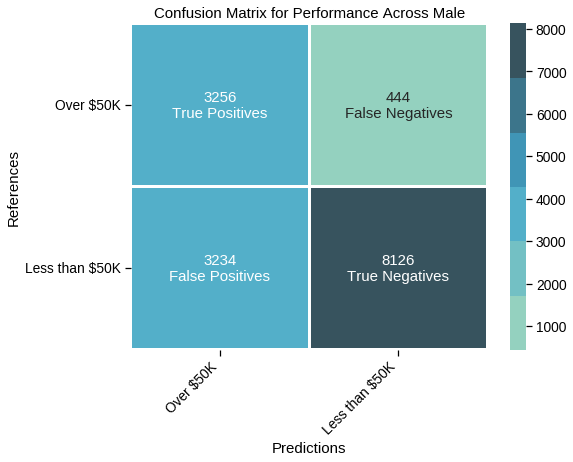

In [25]:
# subgroup_results = model.evaluate(x=features, y=labels, verbose=0)
# tp - fp - tn - fn 
confusion_matrix = np.array([[TPs, FNs], 
                             [FPs, TNs]])

subgroup_performance_metrics = {
    'ACCURACY': avg_acc,
    'PRECISION': avg_recall, 
    'RECALL': avg_recall,
    'AUC': avg_AUC
}
performance_df = pd.DataFrame(subgroup_performance_metrics, index=[SUBGROUP])
pd.options.display.float_format = '{:,.4f}'.format

plot_confusion_matrix(confusion_matrix, classes, SUBGROUP);
performance_df

### Solution

Click below for some insights we uncovered

Using default parameters, you may find that the model performs better for female than male. Specifically, in our run, we found that both accuracy and AUC for female (0.9137 and 0.9089, respectively) outperformed male (0.7923 and 0.8549, respectively). What is going on here?

Notice the number of true positives (top-left corner) for female is way lower compared to male (479 to 3822). Recall that in Task #1 we noticed a disproportionately high representation of male in the data set (almost 2-to-1). If you further explore the data set using Facets Dive in Task #2 by setting the color to `income_bracket` and one of the axes to `gender`, then you will also find a disproportionately small number of female examples in the higher income bracket, our positive label. 

What this is all suggesting is that the model is **overfitting, particuarly with respect to female and lower income bracket**. In other words, this model will not generalize well, particularly with female data, as it does not have enough positive examples for the model to learn from. It is **not doing that much better with male, either, as there is a disproportionately small number of high income bracket compared to low income bracket** — though not nearly as poorly represented as with female.

Hopefully going through this confusion matrix demonstration you find that the results varies slightly from the overall performance metrics, highlighting the importance of evaluating model performance across subgroup rather than in aggregate.

In your work, make sure that you make a good decision about the tradeoffs between false positives, false negatives, true positives, and true negatives. For example, you may want a very low false positive rate, but a high true positive rate. Or you may want a high precision, but a low recall is okay.  

**Choose your evaluation metrics in light of these desired tradeoffs.**